In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

### Finding the right weights (coefficients and intercept)

[walter.daelemans@uantwerpen.be](mailto:walter.daelemans@uantwerpen.be)

Goal is to find the coefficients and intercept (the weights, the parameters of the model) that are optimal **for a particular train dataset** to predict the y's of the test data. To do that, we find the weights that minimize the **cost**, as measured by a metric such as MSE, on the train data.

In [3]:
# We will use the Taiwan house price data again
df = pd.read_csv("data/real_estate.csv")

In [4]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [5]:
# We take age as input and price as output
# We assume that the complete dataset is the train data

X = df['X2 house age']  # rather than df[['X2 house age']] to get a series of numbers
y = df['Y house price of unit area']

X.shape, y.shape

((414,), (414,))

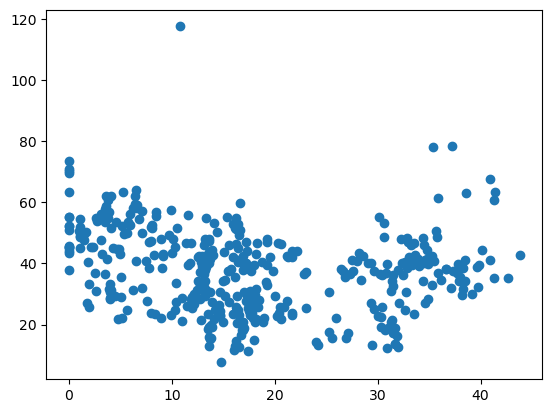

In [6]:
# Plot the datapoints in a scatterplot
plt.scatter(X, y)

MSE: 267.59386473429953


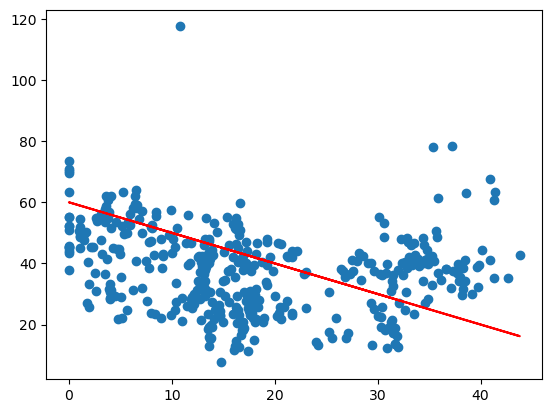

In [7]:
# Next we're going to see what the MSE (Mean Squared Error) is given a specific value of the intercept and the weight

from sklearn.metrics import mean_squared_error

plt.scatter(X, y) 
# Experiment with different values; they give different lines

b = 60
w = -1.0

# we create the predicted y values for the inputs given the intercept and weight
y_pred = [x * w + b for x in X] # the predicted values for each x_value

# we plot the line
plt.plot(X, y_pred, color='Red')

# we compute the mean_squared_error
print(f"MSE: {mean_squared_error(y, y_pred)}")

### How does the linear regression algorithm find the best values for intercept and weight(s)?

#### 1. Exhaustive Search

We could exhaustively look at all combinations of all values of parameters for the best solution (e.g., one loop per parameter in a broad range of values)
  - This would take too long to compute (especially with real values and many parameters)
  - We can't of course try all real values

In [9]:
from ipywidgets import interact

# Create a scatter plot

solutions = [] # we will collect here the parameter values and the corresponding MSE
for b in range(0, 100):
    for w in [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]:
        #print(f"{[b, w]}", end=' ')
        y_pred = [x * w + b for x in X] # generate the predictions
        solutions.append((b, w, mean_squared_error(y, y_pred)))
        
# Function to plot regression lines one by one
def update(index=0):
    plt.scatter(X, y)
    b, w, mse = solutions[index]
    plt.plot(X, [x * w + b for x in X], color='Red')
    plt.title(f"b = {b}, w = {w}, mse = {mse}")
    plt.ylim(y.min(), y.max())
    plt.show()

# Use interact to create a slider and bind it to the update function
interact(update, index=(0, len(solutions)-1));

interactive(children=(IntSlider(value=0, description='index', max=1099), Output()), _dom_classes=('widget-inte…

(42, -0.2, 177.07153043478257)


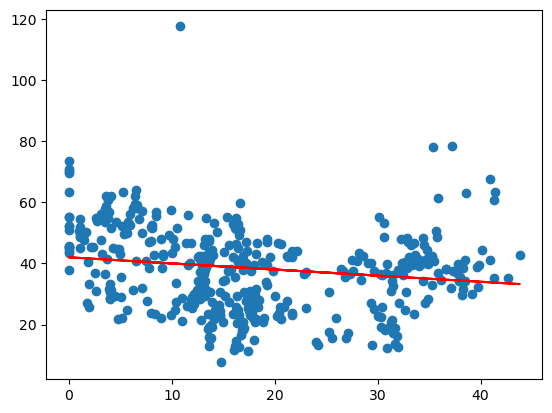

In [10]:
best = min(solutions, key=lambda x: x[2]) # find the minimal MSE and the corresponding parameter values
print(best)
plt.scatter(X, y)
plt.plot(X, [x * best[1] + best[0] for x in X], color='Red');

#### 2. Analytical solution: look for "normal equation"

  - Too computationally expensive for large datasets and only works for linear regression, not for other ML algorithms

#### 3. Heuristic solution: Gradient Descent (GD) 

- Is a heuristic search method that optimizes model parameters by minimizing the overall cost 
  - Computationally efficient
  - Works for many ML algorithms
  - Is the driving force behind training deep neural networks

### Gradient Descent

Our linear regression model has two parameters, weight and intercept and can be written as a function:

$f(X) = w*x + b$ for the univariate LR case and $f(X) = w_1x_1 + w_2x_2 + ... + w_mx_m + b$ for the multiple LR case.

Let's focus on the univariate case:

The **cost function** $J(w, b)$ assigns a cost to each w, b combination. We have to find the one that minimizes the cost *given our training data*. The cost function will be the same here as our evaluation metric: MSE (Mean Squared Error), but in this case we will use it on the train data to find optimal values for the parameters rather than for testing the accuracy of a trained model on unseen test data.

$J(w, b)$ = MSE = $\frac{1}{n}\sum_{i=1}^{n}(f(X_i)-y_i)^2$ for n train items

We can minimize the cost algorithmically:
For each parameter to be optimized by updating them **in parallel**:
- Initialize the parameter randomly
- Update the value of the parameter by finding the *steepest descent*
    - For computing this step we can use the derivative (partial derivative)
- Do this iteratively until you reach the minimum (think of the metaphor of a blindfolded person descending from a mountain step by step looking after each step for the direction that is steepest down)

The partial derivative finds the slope of the tangent line for a specific value of $J(w,b)$. The slope of that line can be positive (in that case we should decrease the value of the parameter to move in the right direction. The slope of the tangent line can also be negative (in that case we should increase the value of the parameter). The absolute value of the slope defines the size of the increase or decrease. The update rules are the following for univariate LR:

- $w = w - \alpha \frac{\partial}{\partial w} J(w, b)$ 
- $b = b - \alpha \frac{\partial}{\partial b} J(w, b)$ 
    
$\alpha$ is the learning rate, it determines the size of the step you will take (keep it small, but not too small e.g., 0.01). If the step is too small it takes too long to reach the minimum, if the step is too big, you may overshoot the mark repeatedly.

We are not going into calculus here (how to compute derivatives). For the MSE cost function, the derivative can be rewritten mathematically (and implemented in Python) as follows. 

- $w = w - \alpha \frac{1}{n}\sum_{i=1}^{n}(w * X_i + b - y_i) * X_i$ 
- $b = b - \alpha \frac{1}{n}\sum_{i=1}^{n}(w * X_i + b - y_i)$ 

<img src="figures/gradient-descent.jpeg">  

[Image from Saugat Bhattarai]

#### Variations of GD

The GD algorithm can be applied either to all training data (**batch** GD), for one example (**stochastic** GD), or a combination of these methods (**minibatch** GD).

There are many different cost functions in ML. To use GD, it should be possible to compute a derivative for the cost function (it should be convex, bowl-shaped) so that we don't get stuck in local minima.

Cost functions and GD will return in this course and other courses later!

The minimum you find may be a **Local Minimum**!

 <img src="figures/extrema.png" width="500" >  
 
 
 (Image from Wikipedia)

#### A Python implementation of GD

In [17]:
from sklearn.preprocessing import StandardScaler
# convert directly to numpy array with .values
y = df['Y house price of unit area'].values
X = df[['X2 house age']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


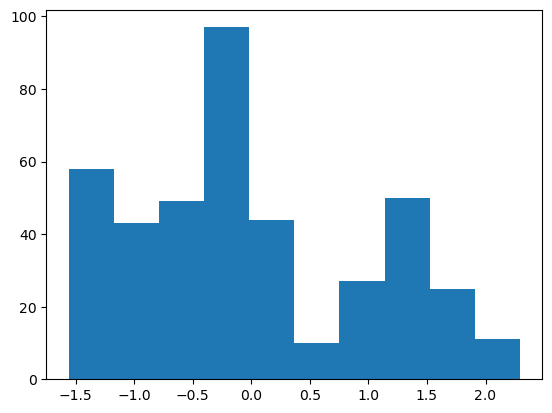

In [18]:
plt.hist(X_scaled);

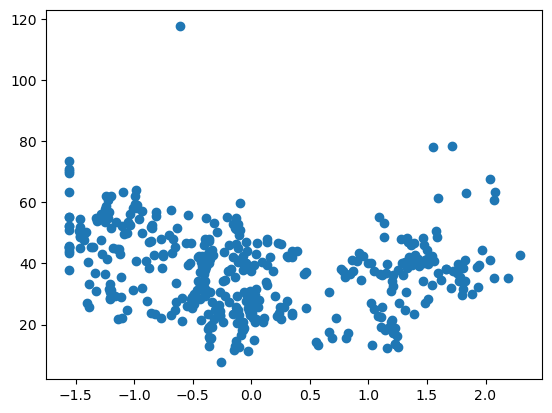

In [19]:
plt.scatter(X_scaled, y);

In [20]:
def compute_cost(X, y, w, b):
    '''Compute the Mean Squared Error (MSE)'''
    y_pred = w * X + b  
    return np.mean((y - y_pred) ** 2)

In [21]:
def gradient_descent(X, y, w=None, b=None, learning_rate=0.001, num_iterations=50):
    '''Perform gradient descent on w and b'''
    n = len(y)
    
    # Initialize w and b randomly if not provided
    if w is None:
        w = np.random.randn(X.shape[1])  # Adjust for multiple features, from a normal distribution
    if b is None:
        b = np.random.randn()  # Single random scalar value
    print(w)
    print(b)
    
    
    # for visualization:
    cost_history = []  
    w_history = []
    b_history = []

    for _ in range(num_iterations):
        # Compute the predictions
        y_pred = w * X + b
        
        # Compute the gradients
        dw = -2/n * np.sum(X * (y - y_pred))
        db = -2/n * np.sum(y - y_pred)
        
        # Update w and b
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Track cost and parameters
        cost_history.append(compute_cost(X, y, w, b))
        w_history.append(w)
        b_history.append(b)

    return w, b, cost_history, w_history, b_history

In [22]:
w, b, cost_history, w_history, b_history = gradient_descent(X_scaled, y)

[1.00937615]
-1.1450786982631769


In [23]:
print(w)
print(b)
print(cost_history[0])

[1.73554653e-16]
37.980193236714975
230.00625897313984


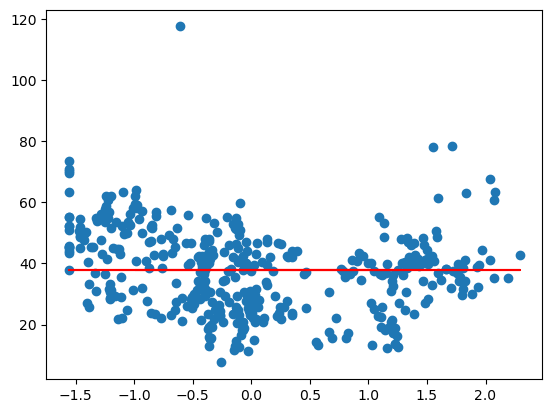

In [24]:
plt.scatter(X_scaled,y)
plt.plot(X_scaled, [x * w + b for x in X_scaled], color='Red');

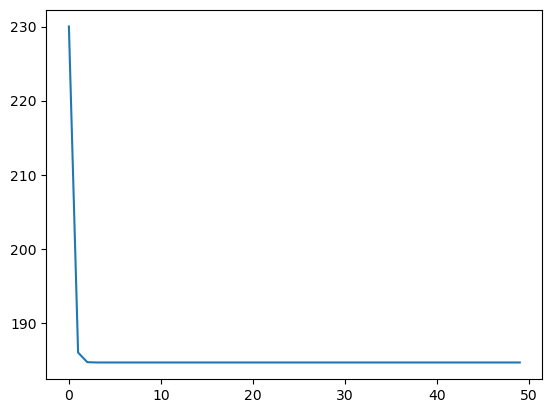

In [25]:
plt.plot(cost_history)

In [26]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_history(w_history, b_history, cost_history):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(w_history, b_history, cost_history, c=cost_history, cmap='coolwarm', marker='o')
    
    ax.set_xlabel('Weight (w)')
    ax.set_ylabel('Bias (b)')
    ax.set_zlabel('Cost')
    ax.set_title('3D plot of GD on w and b')
    ax.view_init(elev=25, azim=30)  # Adjust the viewing angle for better visualization
    plt.show()

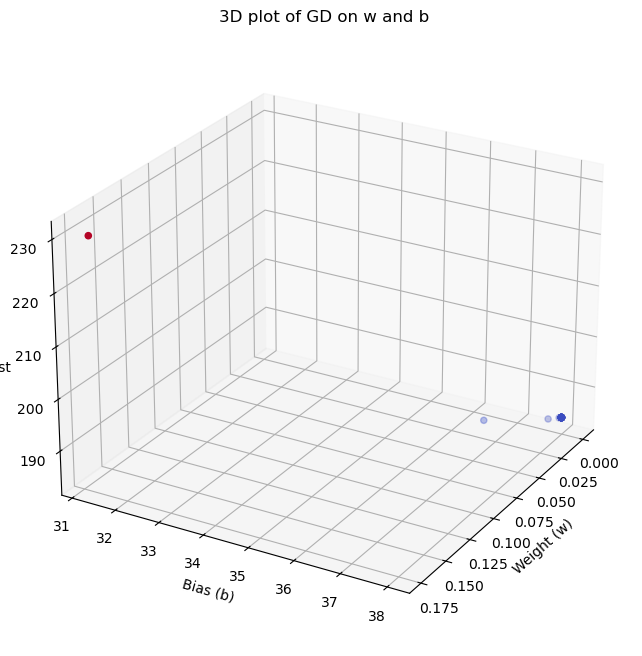

In [27]:
plot_3d_history(w_history, b_history, cost_history)

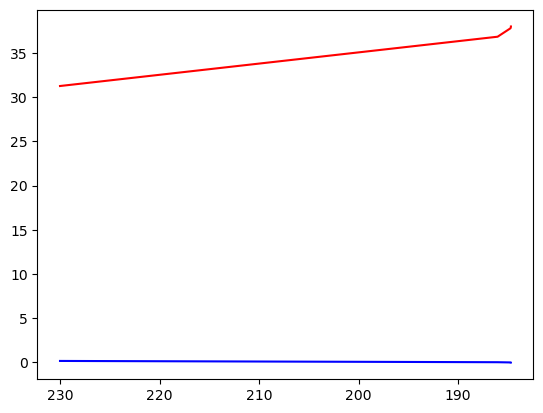

In [28]:
plt.gca().invert_xaxis()
plt.plot(cost_history, w_history, color='blue')
plt.plot(cost_history, b_history, color='red')

#### Further reading on Linear Regression and Gradient Descent

- The sklearn documentation (as always)
- https://mlu-explain.github.io/linear-regression/ with good interactive graphs 
- https://saugatbhattarai.com.np/what-is-gradient-descent-in-machine-learning/ (with videos by Andrew Ng (unfortunately fairly old))
